https://github.com/NeuroTechX/dl-eeg-playground/blob/master/brainDecode/2%20-%20Two-Classes%20Classification%20(BNCI)%20Colab.ipynb

Warning: This needs CUDA! If you don't have it, it won't work.

In [1]:
#!pip install braindecode==0.4.85 -q

In [2]:
#!pip3 install wheel==0.34.1

In [1]:
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from torch import optim
import torch
import numpy as np

In [2]:
# http://pytorch.org/
from os import path
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

Now, let's load data.

We read the file for the desired subject, and parse the data to extract:
- samplingRate
- trialLength
- X, a M x N x K matrix, which stands for trial x chan x samples
    - the actual values are 160 x 15 x 2560
- y, a M vector containing the labels {0,1}

ref: Dataset description: https://lampx.tugraz.at/~bci/database/002-2014/description.pdf

In [5]:
from share import datasets_basic_infos, ROOT_VOTING_SYSTEM_PATH
from data_loaders import load_data_labels_based_on_dataset
from data_utils import train_test_val_split
# Manual Inputs
subject_id = 29  # Only two things I should be able to change
dataset_name = "braincommand"  # Only two things I should be able to change
array_format = True

# Folders and paths
dataset_foldername = dataset_name + "_dataset"
computer_root_path = ROOT_VOTING_SYSTEM_PATH + "/Datasets/"
data_path = computer_root_path + dataset_foldername
dataset_info = datasets_basic_infos[dataset_name]

epochs, _, _ = load_data_labels_based_on_dataset(
    dataset_info, subject_id, data_path, threshold_for_bug = 0.00000001
)
target_names = dataset_info["target_names"]

data = (epochs.get_data() * 1e6).astype(np.float32)
label = epochs.events[:,2].astype(np.int64)

label_copy = label.copy()
for i, label_i in enumerate(label_copy):
    if label_i == 1:
        label[i] = 1
    else:
        label[i] = 0  

x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_val_split(dataX=data, dataY=label, valid_flag=False)

label 0 is 24
label 1 is 40
label 2 is 27
label 3 is 33
Not setting metadata
124 matching events found
Setting baseline interval to [0.0, 1.396] s
Applying baseline correction (mode: mean)
0 projection items activated


Load the models:

In [6]:
train_set = SignalAndTarget(x_train, y=y_train)
test_set = SignalAndTarget(x_test, y=y_test)

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = torch.cuda.is_available()
set_random_seeds(seed=20180505, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]

# final_conv_length = auto ensures we only get a single output in the time dimension
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2],

                        n_filters_time=10,
                        filter_time_length=75,
                        n_filters_spat=5,
                        pool_time_length=60,
                        pool_time_stride=30,

                        #n_filters_time=10,
                        #filter_time_length=90,
                        #n_filters_spat=1,
                        #pool_time_length=45,
                        #pool_time_stride=15,

                        final_conv_length='auto'
                        ).create_network()
if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters())

Load optimizer. You can find hyperparameters in the link below.  
http://pytorch.org/docs/master/optim.html

Finally start training:

In [7]:
from braindecode.torch_ext.util import np_to_var, var_to_np
from braindecode.datautil.iterators import get_balanced_batches
import torch.nn.functional as F
from numpy.random import RandomState
rng = RandomState(None)
#rng = RandomState((2017,6,30))

nb_epoch = 160
loss_rec = np.zeros((nb_epoch,2))
accuracy_rec = np.zeros((nb_epoch,2))


for i_epoch in range(nb_epoch):

    # get a set of balanced batches
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                            batch_size=32)


    # Set model to training mode
    model.train()

    # go through all batches
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X
        batch_X = train_set.X[i_trials][:,:,:,None]
        batch_y = train_set.y[i_trials]
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y).type(torch.LongTensor)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        print(net_target)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()

    # Print some statistics each epoch
    model.eval()
    print("Epoch {:d}".format(i_epoch))

    sets = {'Train' : 0, 'Test' : 1}
    for setname, dataset in (('Train', train_set), ('Test', test_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, batch_size=32, shuffle=False)
        outputs = []
        net_targets = []
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:,:,:,None]
            batch_y = dataset.y[i_trials]

            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
            net_target = var_to_np(net_target)
            output = var_to_np(model(net_in))
            outputs.append(output)
            net_targets.append(net_target)
        net_targets = np_to_var(np.concatenate(net_targets))
        outputs = np_to_var(np.concatenate(outputs))
        loss = F.nll_loss(outputs, net_targets)

        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        loss_rec[i_epoch, sets[setname]] = var_to_np(loss)

        predicted_labels = np.argmax(var_to_np(outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        print("{:6s} Accuracy: {:.1f}%".format(
            setname, accuracy * 100))
        accuracy_rec[i_epoch, sets[setname]] = accuracy

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1])
Epoch 0
Train  Loss: 0.90273
Train  Accuracy: 44.1%
Test   Loss: 0.67137
Test   Accuracy: 54.8%
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1])
Epoch 1
Train  Loss: 0.79655
Train  Accuracy: 61.3%
Test   Loss: 0.57212
Test   Accuracy: 67.7%
tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 

In [8]:
print(max(accuracy_rec[:,1]))

0.7741935483870968


In [9]:
def smoothing(record, smoothingRadius):
 if record.shape[0] > 2 * smoothingRadius :
   record_smooth = np.zeros((record.shape[0] - (2 * smoothingRadius), record.shape[1]))

   for i in range(record_smooth.shape[0]):
     for j in range(record_smooth.shape[1]):
       record_smooth[i,j] = record[i:i+2*smoothingRadius,j].mean()

 return record_smooth


# Define smoothing radius here
smoothingRadius = 10

population_loss_rec = loss_rec
population_accuracy_rec = accuracy_rec
population_loss_smooth = smoothing(loss_rec, smoothingRadius)
population_accuracy_smooth = smoothing(accuracy_rec, smoothingRadius)


In [10]:

print(model)

# save/load only the model parameters(prefered solution)
torch.save(model.state_dict(), "myModel.pth")



Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 10, kernel_size=(75, 1), stride=(1, 1))
  (conv_spat): Conv2d(10, 5, kernel_size=(1, 8), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(60, 1), stride=(30, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(5, 2, kernel_size=(8, 1), stride=(1, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=_squeeze_final_output)
)


In [11]:
# load the saved network (makes it possible to run bottom form same starting point
model.load_state_dict(torch.load("myModel.pth"))

#from google.colab import files
#files.download('example.txt')

<All keys matched successfully>

In [12]:


from torch.nn import init

for param in model.conv_classifier.parameters():
    param.requires_grad = False

model.conv_classifier = nn.Conv2d(5, 2,(116, 1), bias=True).cuda()

optimizer = optim.Adam(model.conv_classifier.parameters(),lr=0.00006)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:

from braindecode.torch_ext.util import np_to_var, var_to_np
from braindecode.datautil.iterators import get_balanced_batches
import torch.nn.functional as F
from numpy.random import RandomState
rng = RandomState(None)
#rng = RandomState((2017,6,30))

nb_epoch = 100
loss_rec = np.zeros((nb_epoch,2))
accuracy_rec = np.zeros((nb_epoch,2))



def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10% every 30 epochs"""
    lr = 0.00006 * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


for i_epoch in range(nb_epoch):
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                            batch_size=32)


    adjust_learning_rate(optimizer,i_epoch)


    # Set model to training mode
    model.train()


    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X
        batch_X = train_set.X[i_trials][:,:,:,None]
        batch_y = train_set.y[i_trials]
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()

    # Print some statistics each epoch
    model.eval()
    print("Epoch {:d}".format(i_epoch))

    sets = {'Train' : 0, 'Test' : 1}
    for setname, dataset in (('Train', train_set), ('Test', test_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, batch_size=32, shuffle=False)
        outputs = []
        net_targets = []
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:,:,:,None]
            batch_y = dataset.y[i_trials]

            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
            net_target = var_to_np(net_target)
            output = var_to_np(model(net_in))
            outputs.append(output)
            net_targets.append(net_target)
        net_targets = np_to_var(np.concatenate(net_targets))
        outputs = np_to_var(np.concatenate(outputs))
        loss = F.nll_loss(outputs, net_targets)

        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        loss_rec[i_epoch, sets[setname]] = var_to_np(loss)

        predicted_labels = np.argmax(var_to_np(outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        print("{:6s} Accuracy: {:.1f}%".format(
            setname, accuracy * 100))
        accuracy_rec[i_epoch, sets[setname]] = accuracy

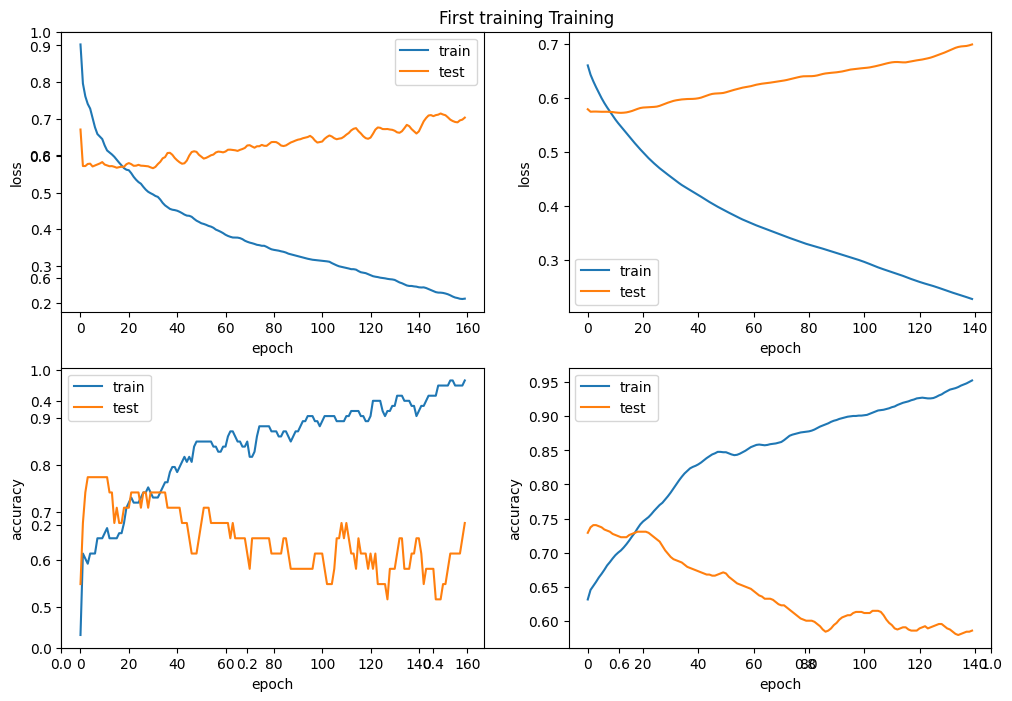

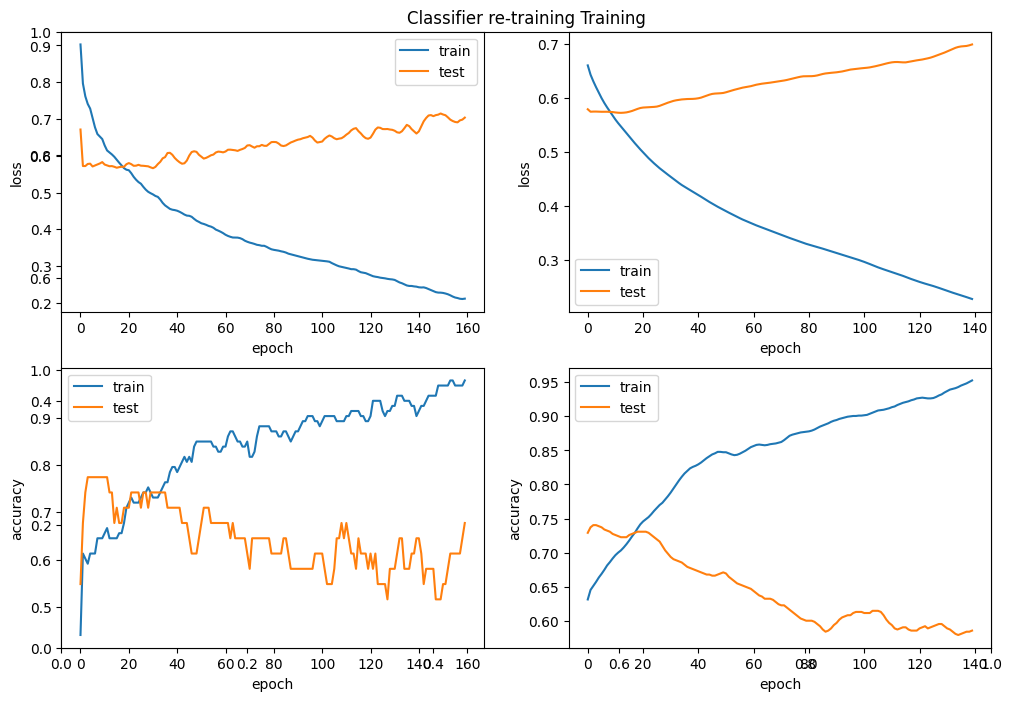

In [13]:

individual_loss_rec = loss_rec
individual_accuracy_rec = accuracy_rec
individual_loss_smooth = smoothing(loss_rec, smoothingRadius)
individual_accuracy_smooth = smoothing(accuracy_rec, smoothingRadius)

import matplotlib.pyplot as plt


plt.figure(figsize=(12,8))
plt.title('First training Training')
plt.subplot(221)
handles = plt.plot(population_loss_rec)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(222)
handles = plt.plot(population_loss_smooth)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(223)
handles = plt.plot(population_accuracy_rec)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(224)
handles = plt.plot(population_accuracy_smooth)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.show()

plt.figure(figsize=(12,8))
plt.title('Classifier re-training Training')
plt.subplot(221)
handles = plt.plot(individual_loss_rec)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(222)
handles = plt.plot(individual_loss_smooth)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(223)
handles = plt.plot(individual_accuracy_rec)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(224)
handles = plt.plot(individual_accuracy_smooth)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.show()




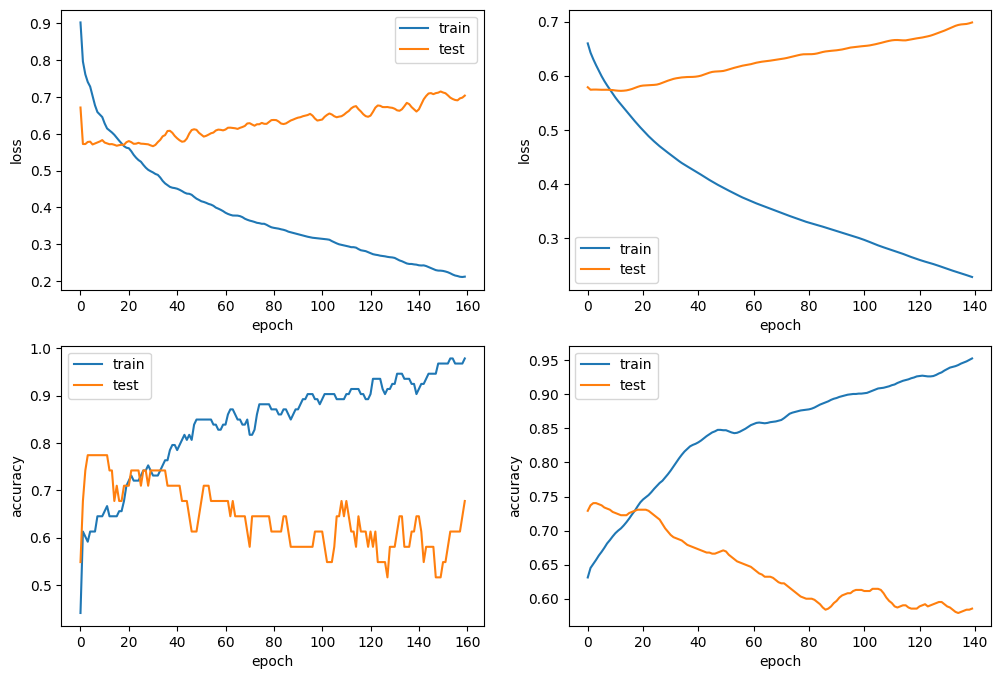

In [14]:



plt.figure(figsize=(12,8))
plt.subplot(221)
handles = plt.plot(population_loss_rec)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(222)
handles = plt.plot(population_loss_smooth)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(223)
handles = plt.plot(population_accuracy_rec)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(224)
handles = plt.plot(population_accuracy_smooth)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.show()